In [13]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import math
import random
import pickle
import copy

In [14]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

n_class = len(labels)

In [15]:
class Hypersphere_abstain:
    
    def __init__(self, center, radius, threshold, label, alpha, beta, D, err, weighted_err, unweighted_err,
                 label_confidences, label_distribution, center_index, neighbor_indices, d_var, max_q_var):
        
        self.center = center
        self.radius = radius
        self.thres = threshold
        self.label = label
        self.alpha = alpha
        self.beta = beta
        self.D = D 
        self.pseudo_err = err # PSEUDO error
        self.weighted_err = weighted_err
        self.unweighted_err = unweighted_err
        self.label_confidences = label_confidences
        self.label_distribution = label_distribution
        self.center_index = center_index
        self.neighbor_indices = neighbor_indices
        
        # Hack
        self.d_var = d_var
        self.max_q_var = max_q_var
        
class WeakLearner_generator:
    
    def __init__(self, init_radius, growth_radius, end_radius, err_thres):
        
        self.init_radius = init_radius
        self.growth_radius = growth_radius
        self.end_radius = end_radius
        self.err_thres = err_thres
        
    def generate_pseudo(self, train_X, train_y, train_kernel, D, Q, mask, n_class):
        
        n_samples = train_X.shape[0]
        D = D.reshape((n_samples, ))

        # Choose an exemplar
        exemplar_index = np.random.choice(range(n_samples), p=D.tolist())
        exemplar = train_X[exemplar_index]

        # Retrieve scores to exemplar and sort
        scores = train_kernel[exemplar_index]
        sorted_scores = np.sort(scores)[::-1]
        sorted_indices = np.argsort(scores)[::-1]
        sorted_y = train_y[sorted_indices].astype('int64')
        sorted_D = D[sorted_indices]
        sorted_Q = Q[sorted_indices]
        sorted_mask = mask[sorted_indices]
        
        # Calculate plurarity and percentage of initial sphere
        init_size = np.argmax(sorted_scores<self.init_radius)
        count = np.bincount(sorted_y[:init_size],
                            weights=sorted_D[:init_size],
                            minlength=n_class)
        unweighted_count = np.bincount(sorted_y[:init_size],
                                       minlength=n_class)
        y_of_interest = np.argmax(count)
        percentage = count[y_of_interest]*1.0 / np.sum(sorted_D[:init_size])

        # Abstain test (HACK to avoid zero threshold)
        if np.sum(sorted_scores)==0.0:
            return None, None
        
        # Calculate cumulative weight sums
        sorted_D_tile = np.tile(sorted_D.reshape((n_samples,1)), (1, n_class))
        label_D_cum = np.cumsum(sorted_D_tile*sorted_mask, axis=0)
        label_Dq_cum = np.cumsum(sorted_D_tile*~sorted_mask*sorted_Q, axis=0)

        # Hypothesis and pseudo loss
        radii = np.arange(self.end_radius, self.init_radius+self.growth_radius, self.growth_radius)[::-1]
        hypo = np.zeros((len(radii), n_class), dtype=bool)
        pseudo_loss = np.zeros((len(radii),1))
        
        # For each radius
        for c,r in enumerate(radii):
            
            i = np.argmax(sorted_scores<r)
            
            # Calculate best hypotheses
            deriv = -1.0*label_D_cum[i-1]+label_Dq_cum[i-1]
            hypo[c] = (deriv<0.0).astype('float')
            label_conf = np.tile(hypo[c], (n_samples, 1))
    
            # Calculate three terms in pseudo loss
            ones_term = np.ones((n_samples,1)).astype('float')
            label_term = np.sum(sorted_mask*label_conf, axis=1).reshape((n_samples,1)).astype('float')
            nonlabel_sum = np.sum(~sorted_mask*sorted_Q*label_conf, axis=1).reshape((n_samples,1)).astype('float')
            
            # Calculate pseudo loss
            pseudo_loss[c] = 0.5 * np.sum(sorted_D[:i].reshape((i,1))*(ones_term[:i] - label_term[:i] + nonlabel_sum[:i]))
            pseudo_loss[c] += 0.5 * np.sum(sorted_D[i:])
            
            
        # Calculate best radius
        best_idx = np.argmin(pseudo_loss)
        best_radius = np.argmax(sorted_scores<radii[best_idx])
        
        # Prediction by best radius hypothesis
        label_conf = hypo[best_idx]
        p_err = pseudo_loss[best_idx]
        
#         if random.random()<0.001:
#             print 'BEST (Size, Ploss, Hypo): ', (best_radius, list(p_err), list(label_conf.astype('int')))

        # Calculate label distritbution
        label_distribution = np.bincount(sorted_y[:best_radius], minlength=n_class)
    
        # Error test
        if p_err>self.err_thres:
            return None, None
        
        # Calculate alpha
        epsilon = 1.0e-24
        alpha = math.log((1.0-p_err+epsilon)/(p_err+epsilon))
        beta = (p_err+epsilon)*1.0/(1.0-p_err-epsilon)

        # Return weakleaner
        err = 0.0
        w_err = 0.0
        threshold = sorted_scores[best_radius-1]
        
        d_var = np.var(D)
        max_q_var= np.max(np.var(sorted_Q, axis=1))
        
        h = Hypersphere_abstain(exemplar, best_radius, threshold, y_of_interest,
                                alpha, beta, D, p_err, w_err, err, label_conf, label_distribution,
                                exemplar_index, sorted_indices, d_var, max_q_var)
        
        return h, sorted_mask
    

In [18]:
# Adaboost.M2

class Adaboost_M2:
    
    def __init__(self, iterations, n_class, weaklearner):
        
        self.T = iterations
        self.H = []
        self.D = None
        self.Q = None
        self.W = None
        self.label_mask = None
        self.n_class = n_class
        self.weaklearner = weaklearner
    
    def train(self, train_X, train_y, train_kernel):
        
        n_samples = train_X.shape[0]
        
        # Create column mask for weights
        rows = list(xrange(n_samples))
        cols = train_y.astype('int64').tolist()
        self.label_mask = np.zeros((n_samples, self.n_class), dtype=bool)
        self.label_mask[rows, cols] = True
        
        # Initialize weights
        self.D = np.ones((n_samples, 1))*(1.0/n_samples)
        self.W = np.zeros((n_samples, self.n_class)) + \
                    ~self.label_mask*np.tile(self.D, (1,n_class))*(1.0/(self.n_class-1))

        for t in xrange(self.T):

            if t%1000==0:
                print 't: ', t
                
            # Normalize
            W_sum = np.sum(self.W, axis=1).reshape((n_samples,1))
            self.Q = np.zeros((n_samples, self.n_class)) + \
                        self.W*1.0/np.tile(W_sum,(1,self.n_class))
            self.D = W_sum*1.0/np.sum(W_sum)
            
            # Generate weaklearner
            h, h_neighbor_label_mask = \
                self.weaklearner.generate_pseudo(train_X, train_y, train_kernel, self.D, self.Q, self.label_mask, self.n_class)
            
            # Check abstained
            if not h:
                continue
                
            self.H.append(h)

            # Reweight
            base_term = h.beta*np.ones((n_samples, self.n_class))
            ones_term = np.ones((n_samples, self.n_class)).astype('float')
            label_weights = np.tile(h.label_confidences.reshape((1, self.n_class)), (n_samples, 1))
            label_term = np.sum(h_neighbor_label_mask*label_weights, axis=1).reshape((n_samples, 1))
            label_term = np.tile(label_term, ((1, self.n_class))).astype('float')
            nonlabel_term = ~h_neighbor_label_mask*label_weights.astype('float')
            
            power_term = 0.5*(ones_term + label_term - nonlabel_term)
            
            neighbors_in_sphere = h.neighbor_indices[:h.radius]
            neighbors_out_sphere = h.neighbor_indices[h.radius:]
    
            self.W[neighbors_in_sphere] = self.W[neighbors_in_sphere] * \
                                            np.power(base_term[:h.radius], power_term[:h.radius])
            self.W[neighbors_out_sphere] = self.W[neighbors_out_sphere] * \
                                            np.power(base_term[h.radius:], 0.5*ones_term[h.radius:])

        print 'Num classifiers: ', len(self.H)

    def predict(self, train_X, train_y, train_kernel=None):

        no_kernel = train_kernel==None
        n_samples = train_X.shape[0]
        cumulative_prob = np.zeros((n_samples, self.n_class)).astype('float')
        staged_pred_y = np.zeros((len(self.H), n_samples)).astype('int64')
#         print 'n: ', n_samples
        
        if no_kernel:
            
            def compute_intersection_kernel_oneJob(i):
                dist = np.minimum(self.H[i].center, test_X)
                dist = np.sum(dist, axis=1).reshape((1, n_samples))
                return dist
            
            score_kernel = np.concatenate([compute_intersection_kernel_oneJob(i) for i in xrange(len(self.H))], axis=0)
            print 'Test kernel shape: ', score_kernel.shape
            
        else:
            score_kernel = None

        for i in xrange(len(self.H)):
            
            clf = self.H[i]
            
            score = np.copy(score_kernel[i]) if no_kernel else np.copy(train_kernel[clf.center_index])
            score[score < clf.thres] = 0.0 #Abstain
            score[score >= clf.thres] = math.log(1.0/clf.beta)
            
            label_weights = clf.label_confidences.astype('float')
            cumulative_prob += np.multiply(score.reshape((n_samples,1)), label_weights.reshape((1,self.n_class)))

            max_prob = np.max(cumulative_prob, axis=1)
            pred_y = np.argmax(cumulative_prob, axis=1)
            pred_y[max_prob==0.0] = 0
            staged_pred_y[i,:] = pred_y
        
        print 'Correct predictions: ', np.sum(train_y==staged_pred_y[-1])
        
        return staged_pred_y



Experiment #0
(5969, 200) (5969, 5969) 373.0625
(4462, 200) (4462, 4462) 278.875
(3729, 200) (3729, 3729) 233.0625
(2224, 200) (2224, 2224) 139.0
(745, 200) (745, 745) 46.5625
(1495, 200) 93.4375
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers: 

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in double_scalars
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:69: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


 9236
Correct predictions:  4321
Test kernel shape:  (9236, 1495)
Correct predictions:  825
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  9148
Correct predictions:  3421
Test kernel shape:  (9148, 1495)
Correct predictions:  821
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  9136
Correct predictions:  2960
Test kernel shape:  (9136, 1495)
Correct predictions:  812
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  8858
Correct predictions:  1988
Test kernel shape:  (8858, 1495)
Correct predictions:  773
t:  0
t:  1000
t:  2000
t:  3000
t:  4000
t:  5000
t:  6000
t:  7000
t:  8000
t:  9000
Num classifiers:  7747
Correct predictions:  727
Test kernel shape:  (7747, 1495)
Correct predictions:  689
Training 80:  5969
Final Accuracy:  0.723906852069
Testing 80:  1495
Final Accuracy:  0.551839464883
Training 60:  4462
Final

Experiment #0 time: 962.743818 seconds


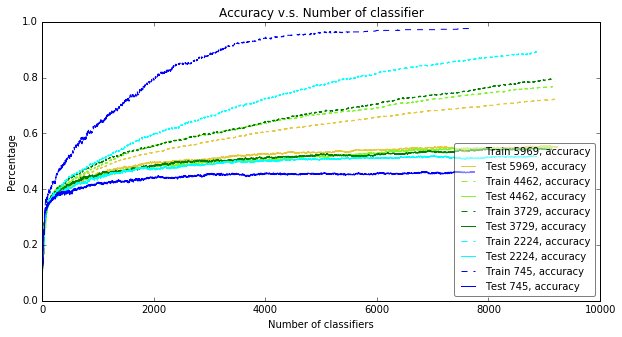

In [27]:
# LEVEL=0, 500patches, 8-2 and 6-4 and 5-5 and 3-7 and 1-9

exprmt = 1
train_frac = [0.8, 0.6, 0.5, 0.3, 0.1] #Descending, same as in dataset_experiments_sametest.py

# for e in [0, 1]:
for e in xrange(exprmt):
    
    print '\nExperiment #%d' %e
    
    tim = time.time()

    # Load preprocessed data
    train_X = [None for tf in train_frac]
    train_y = [None for tf in train_frac]
    train_kernel = [None for tf in train_frac]
    train_fnames = [None for tf in train_frac]
    train_y_per_class = [None for tf in train_frac]
    staged_pred_y = [None for tf in train_frac]
    staged_pred_y_test = [None for tf in train_frac]
    
    for f in xrange(0, len(train_frac)):
        train_X[f] = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_t%d_e%d_data.bp'%(int(train_frac[f]*100),e))
        train_y[f] = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_t%d_e%d_labels.bp'%(int(train_frac[f]*100),e))
        train_kernel[f] = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_t%d_e%d_spm_dist_mat.bp'%(int(train_frac[f]*100),e))
        train_fnames[f] = bp.unpack_ndarray_file('sift-jpeg/preprocessed/train_level0_t%d_e%d_fnames.bp'%(int(train_frac[f]*100),e))
        train_y_per_class[f] = np.mean(np.bincount(train_y[f].astype(int), minlength=16))
        print train_X[f].shape,
        print train_kernel[f].shape,
        print train_y_per_class[f]
    
    test_X = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_level0_t%d_e%d_data.bp'%(100-int(train_frac[0]*100),e))
    test_y = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_level0_t%d_e%d_labels.bp'%(100-int(train_frac[0]*100),e))
    test_fnames = bp.unpack_ndarray_file('sift-jpeg/preprocessed/test_level0_t%d_e%d_fnames.bp'%(100-int(train_frac[0]*100),e))
    test_y_per_class = np.mean(np.bincount(test_y.astype(int), minlength=16))
    print test_X.shape,
    print test_y_per_class
    
    # Setup, Train, and Predict
    for f in xrange(0, len(train_frac)):
        weak = WeakLearner_generator(init_radius=0.5,
                                     growth_radius=0.05,
                                     end_radius=0.0,
                                     err_thres=1.0)
        ada = Adaboost_M2(iterations=20000, 
                          n_class=n_class, 
                          weaklearner=weak)
        ada.train(train_X[f], train_y[f], train_kernel[f])
        staged_pred_y[f] = ada.predict(train_X[f], train_y[f], train_kernel[f])
        staged_pred_y_test[f] = ada.predict(test_X, test_y)
        del weak
        del ada
    
    # Calculate accuracy
    train_acc = [None for tf in train_frac]
    n_training = [None for tf in train_frac]
    t_training = [None for tf in train_frac]
    test_acc = [None for tf in train_frac]
    n_testing = [None for tf in train_frac]
    t_testing = [None for tf in train_frac]
    
    for f in xrange(0, len(train_frac)):
        train_acc[f] = []
        n_training[f] = staged_pred_y[f].shape[1]
        t_training[f] = len(staged_pred_y[f])
        test_acc[f] = []
        n_testing[f] = staged_pred_y_test[f].shape[1]
        t_testing[f] = len(staged_pred_y_test[f])
        for t in xrange(t_training[f]):
            train_acc[f].append(np.sum(staged_pred_y[f][t]==train_y[f])*1.0/n_training[f])
            test_acc[f].append(np.sum(staged_pred_y_test[f][t]==test_y)*1.0/n_testing[f])
        print 'Training %d: '%int(train_frac[f]*100), n_training[f]
        print 'Final Accuracy: ', train_acc[f][-1]
        print 'Testing %d: '%int(train_frac[f]*100), n_testing[f]
        print 'Final Accuracy: ', test_acc[f][-1]

    plt.figure(figsize=(10,5));
    plt.title("Accuracy v.s. Number of classifier");
    plt.xlabel("Number of classifiers");
    plt.ylabel("Percentage");
    plt.ylim([0.0, 1.0]);
    
    colors = ['#E5C93D','#83F52C','green','cyan','blue']
    for f in xrange(0, len(train_frac)):
        plt.plot(range(1, len(train_acc[f]) + 1), train_acc[f], label='Train %d, accuracy'%n_training[f], linestyle='dashed', color=colors[f]);
        plt.plot(range(1, len(test_acc[f]) + 1), test_acc[f], label='Test %d, accuracy'%n_training[f], color=colors[f]);
#     plt.hlines(0.95, 1, 17800, linestyles=':', color='grey');
#     plt.hlines(0.60, 1, 17800, linestyles=':', color='grey');
    plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);
    
    print ''
    del train_X
    del train_y
    del train_kernel
    del train_fnames
    del test_X
    del test_y
    del test_fnames
    del staged_pred_y
    del staged_pred_y_test

    sys.stderr.write('Experiment #%d time: %f seconds\n' % (e, (time.time() - tim))) # ~ 2s / 12k training data

In [29]:
per_class = [370, 280, 230, 140, 45]

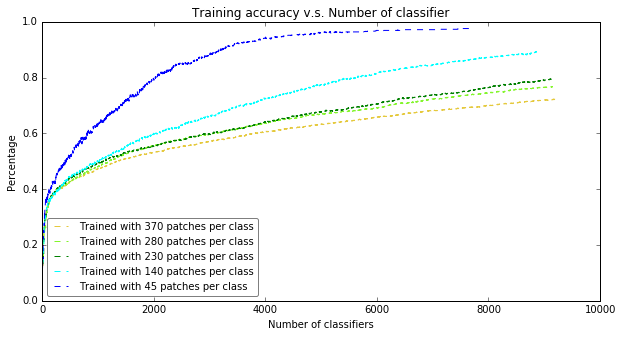

In [30]:
# Train accuracies

colors = ['#E5C93D','#83F52C','green','cyan','blue']

plt.figure(figsize=(10,5));
plt.title("Training accuracy v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage");
plt.ylim([0.0, 1.0]);
for f in xrange(0, len(train_frac)):
    plt.plot(range(1, len(train_acc[f]) + 1), train_acc[f], label='Trained with %d patches per class'%per_class[f], linestyle='dashed', color=colors[f]);
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);

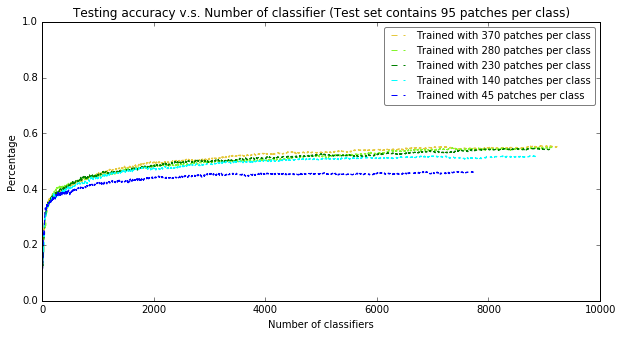

In [33]:
# Test accuracies

plt.figure(figsize=(10,5));
plt.title("Testing accuracy v.s. Number of classifier (Test set contains 95 patches per class)");
plt.xlabel("Number of classifiers");
plt.ylabel("Percentage");
plt.ylim([0.0, 1.0]);
for f in xrange(0, len(train_frac)):
    plt.plot(range(1, len(test_acc[f]) + 1), test_acc[f], label='Trained with %d patches per class'%per_class[f], linestyle='dashed', color=colors[f]);
plt.hlines(0.58, 1, 18000, linestyles=':', color='grey');
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10);

In [32]:
acc = [None for tf in train_frac]
acc[0] = np.array([0.585284280936,0.583946488294,0.596655518395,0.589966555184,0.555852842809])
acc[1] = np.array([0.578595317726,0.571237458194,0.577926421405,0.559866220736,0.55652173913])
acc[2] = np.array([0.566555183946,0.571237458194,0.569899665552,0.572575250836,0.539130434783])
acc[3] = np.array([0.535117056856,0.541806020067,0.532441471572,0.546488294314,0.521070234114])
acc[4] = np.array([0.475585284281,0.484280936455,0.465551839465,0.455518394649,0.434113712375])